In [1]:
import sys
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import exponweib
from scipy.stats import expon
from scipy.stats import norm
from scipy.integrate import quad
from multiprocessing import Pool
from matplotlib.widgets import Slider, Button, RadioButtons
import scipy.interpolate as interpolate
from opt_einsum import contract
import scipy.optimize as opt
import numba as nb

%matplotlib inline

In [2]:
%cd ../
%matplotlib inline

/home/jhutchins/Dropbox/dissertation_proposal/papers/paper1_culling/project_repo


## Culling Model

The culling model of Miranda and Schnitkey (1995) has the following set up (I use the same notation):

### States: $x_t = (a_t,\eta_t,p_t,c_t)$
- $a_t$: age at time $t$
- $\eta_t$: production shock at time $t$
- $p_t$: IOFC at time $t$
- $c_t$: culling cost at time $t$

### Controls: $i_t \in \{0,1\}$
- $i_t$: whether cow is culled at time $t$

### Technology/Flow:
- $y(a_t)= \beta_0 + \beta_1 a_t + \beta_2 a_t^2 + \eta_{t}$: production; assumed to be quadratic in age.
- $p_t = \alpha_{p0} + \alpha_{p1} p_{t-1} + \upsilon_{pt}$: price is AR(1)
- $c_t = \alpha_{c0} + \alpha_{c1} c_{t-1} + \upsilon_{ct}$: cost is AR(1)
- $M(a_t) = \gamma_0 + \gamma_1 a_t $ : cost function; assumed to be linear in age.
- $h(a_t) = da_t^k$: Hazard rate
- $R(a_t,p_t,c_t,i_t) = p_t y(a_t,\eta_t) - M(a_t) - (1-i)h(a_t)(c_t+\alpha) - i c_t $: the return function as a function of states and controls.
- $\eta_{t+1} \sim \begin{cases} N(\rho\eta_{t},\sigma^2_\eta) & i_t=0\\ N(0,\sigma^2_\eta & i_t=1 \end{cases}$


### Parameters: $\theta$
- $\delta \in (0,1)$: discount factor
- $\beta,\alpha,\gamma,\rho$: production, cost, and price parameters
- $d,k$: hazard rate parameters 
- $\mu,\lambda$: GEV error term distribution parameters
- $\upsilon$: Normally distributed error terms for price

### Bellman's Equation:
$$ V(x,i)= \max_{i\in\{0,1\}} R(x,i) +\epsilon(i) + \delta E(V(x',i')|x,i)  $$

### Likelihood
#### Full Information Likelihood:

The likelihood function is thus:
$$L(\theta|x) = \Pi_{j=1}^N Pr(i_j|x_j,\theta)  $$
where the probabilities are:
$$Pr(i|x,\theta) = \frac{exp\lambda[R(x,i) + i\mu + \delta EV_\theta (x,i)]}{\sum_{j=0,1} exp \lambda[R(x,j) + \mu_j + \delta EV_\theta (x,j)] } $$
where we find $EV_\theta$ with the following contraction mapping:
$$EV_\theta (x,i) = E_{x'|x,i} \frac{1}{\lambda} log\Big\{\sum_{j=0,1} exp \lambda [R(x',j) +\mu_j + \delta EV_\theta(x',j) ]\Big\} $$

## 1) The hazard rate

Our only requirement is that $h(a)$ be non decreasing in $a$.  Weibull is a good choice because it has a simple functional form for the hazard: $h(a) = (\frac{k}{d})(\frac{a}{d})^{k-1}$.  The parameters also have some interpretations; $k$ is either less than 1 (decreasing hazard), more than 1 (increasing hazard), or equal to 1 (constant hazard) and $d$ is generally the parameter that, as it decreases, increaases hazard at every level.

First, lets find the empirical probabilities at each age

In [ ]:
data = pd.read_pickle('../data/cleaned_replacement_data.pkl')
death_data= data[data.dest_term_code=='Died on dairy'][['cow_id','cow_herd_id','birth_date','lactation_no','date_left_herd']]
deathtimes = death_data.groupby(['cow_id','cow_herd_id'])['lactation_no'].max().reset_index()

rows = []
for i in range(len(deathtimes)):
    row = deathtimes.iloc[i,:]
    history = pd.DataFrame(np.arange(1,row['lactation_no']+1,1),columns=['lactation_no'])
    history['cow_herd_id'] = row['cow_herd_id']
    rows += [history] 
    
deathhistory = pd.concat(rows)

deathhistory = deathtimes[['cow_herd_id','lactation_no']]\
                .merge(deathhistory,how='outer',indicator='i')\
                .sort_values(['cow_herd_id','lactation_no'])

deathhistory['death'] = (deathhistory['i'] =='both').astype(int)

deathhistory.groupby('lactation_no')['death'].describe()
empirical_death_rates = deathhistory.groupby('lactation_no')['death'].mean()
deathhistory.groupby('lactation_no')['death'].describe()

In [2]:
# Here are probabilities of involuntary culling taken from Stott 1994 for fitting the hazard rate curve.

inv_probs = [.136,.149,.179,.198,.227,.245,.259,.273,.290,.3,.326,.345]

# The following hazard rate curve is based on the Weibull distribution; 
# k>1 implies increasing hazard over time whereas k<1 implies decreasing hazard.

def hw(a,d,k):
    return d*(a)**(k)

T = 12
Tgrid = np.linspace(1,T,T)

opt.curve_fit(hw,Tgrid, inv_probs)

(array([ 0.11410902,  0.42911546]),
 array([[  2.53411483e-05,  -1.04462277e-04],
        [ -1.04462277e-04,   4.59094676e-04]]))

### Demonstrating the effect of the parameters on hazard rates
Warning: interactive graph that does not work in jupyter lab

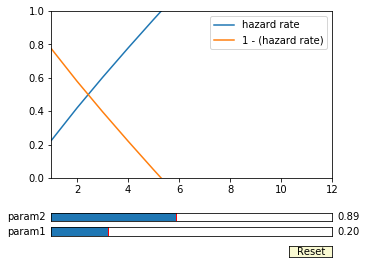

In [3]:

T = 12
Tgrid = np.linspace(1,T,T)
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.3)
plt.xlim(1,12)
plt.ylim(0,1)
hfplot,= plt.plot(Tgrid,hw(Tgrid,.2262454863454647,  .8912351144607027 ),label='hazard rate')
hfplot_,=plt.plot(Tgrid,1-hw(Tgrid,.2262454863454647,  .8912351144607027),label='1 - (hazard rate)')

axcolor = 'lightgoldenrodyellow'
ax1 = plt.axes([0.25, 0.1, 0.65, 0.03])
ax2 = plt.axes([0.25, 0.15, 0.65, 0.03])

s1 = Slider(ax1, 'param1', 0, 1, valinit=.2)
s2 = Slider(ax2, 'param2', 0, 2, valinit=.89)

def update(val):
    val1 = s1.val
    val2 = s2.val
    hfplot.set_ydata(hw(Tgrid,val1,val2))
    hfplot_.set_ydata(1-hw(Tgrid,val1,val2))
    s1.valtext.set_text('{}'.format(val1))
    s2.valtext.set_text('{}'.format(val2))
    ax.relim()
    #ax.autoscale_view(True,True,True)
    fig.canvas.draw_idle()
s1.on_changed(update)
s2.on_changed(update)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')

def reset(event):
    s1.reset()
    s2.reset()
button.on_clicked(reset)
ax.legend()

plt.show()

The second parameter is the $k$ shape parameter, and here it has been estimated as more than 1, implying the hazard rate increases over time at a decreasing rate; $k=1$ implies constant over time, and from the look of the graph the probability of death increases at first and then roughly stays the same.

Since the hazard level is much higher in the DHI data than from the paper, splitting the difference I estimate the model with the parameters $k=1.5$ and $d=4$

## 2) Discretizing Prices

To discretize prices, I rely on the function discrete_AR1 which will do an equal interval approximation of an AR(1) process.  In this case, all we need to do is find three parameters: mu, sig, and rho, all of which can be discovered from an AR(1) regression with normal errors.

In [3]:
from lib.theory_models import discrete_AR1, generate_shocks

In [6]:
# Discretizing into AR(1)

# Load some data in about iofc
y_ = pd.read_csv('../data/iofc.csv')['Value']
yL_ = y_.to_frame().shift(1)['Value'][1:]
y_ = y_[1:]

# Likelihood function for normal errors
def L_price(parms):
    mu = parms[0]
    sig = parms[1]
    rho = parms[2]
    res = y_ - mu*(1-rho) - rho*yL_ 
    return -np.log((2*np.pi*sig**2)**(-len(y_)/2)*np.exp(-(1/(2*sig**2))*sum(res**2)))

from scipy.optimize import minimize

mu,sig,rho = minimize(L_price,np.array([1,1,1])).x

# For replacement cost:
# From M+S (1995)
mrho = .9793
mcons = .345
msig = 31.7710**.5
mmu = mcons/(1-mrho)

/home/jhutchins/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/home/jhutchins/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/jhutchins/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


In [ ]:
prices = discrete_AR1_([mu,sig,rho],equal='interval',d=.1,m=2.7)
replc = discrete_AR1_([mmu,msig,mrho],equal='interval',d=.1,m=5.2)

print(mmu,msig,mrho)
print(mu,sig,rho)

## 2.5) Making production non-deterministic

Now I will make production non-deterministic with autocorrelated errors which implies adding another state variable.  Production is a quadratic function of age $a_t$ and also has AR(1) errors.  It is easiest to make the state variable $y_t = Y(a_t) + \eta_t$ where $Y(a_t)=\beta_0 + \beta_1 a_t + \beta_2 a_t^2$ and define this period's deviation as $\eta_t$.

Assuming that $y_t$ is drawn from a normal distribution and the disturbance is $\eta_t \sim N(0,\sigma^2_\eta)$.  So the probability of drawing a certain value of production, ($y_{t+1}$) is drawing from a mixture distribution because of its dependence on age.

What is the probability of drawing a certain value of $a_{t+1}$?  This is summed up by the following matrix:

|                      | $i_t =1$   | $i_t =0$   |
|----------------------|------------|------------|
|$a_{t+1} =1$          | 1          | $h(a_t)$   | 
|$a_{t+1} = a_t +1$    | 0          | $1-h(a_t)$ |

So choosing $i_t=1$ eliminates any chance of age changing to anything other than 1.  This means if $i_t=1$ then we simply draw from $N(Y(1),\sigma^2_y)$; I ommit the dependence on the previous error because it should be a new cow.  This in theory should incentivize replacement after negative shocks (much like on a real dairy farm).  If $i_t =0$, we actually draw from a mixture distribution:

$y_{t+1} \sim \Big(1-h(a_t)\Big) N\Big(Y(a_t+1) + \rho \eta_t,\sigma^2_\eta\Big) + h(a_t) N\Big(Y(1),\sigma_\eta^2\Big)$

So by the properties of normal distributions 

$y_{t+1} \sim N(\mu^0_{\eta}(a_t,\eta_t),\sigma^2_{i=0}(a_t))$

$\sigma^2_{i=0} = \Big(h(a_t)^2 + (1-h(a_t))^2\Big) \sigma^2_\eta$

$ \mu^0_{\eta}(a_t,\eta_t) = \Big(Y(a_t+1) + \rho \eta_t \Big)(1-h(a_t)) + Y(1)h(a_t)$

So choosing to replace erases history (distribution does not depend on any current states) and also wipes out any chance of negative shocks correlating.


In [ ]:
# Parameters from Miranda and Schnitkey (1995)
Shock,Qe = generate_shocks(9.69,.56,3,.25)

## 3) Model

### 3.1) Example run

In [ ]:
from lib.theory_models import cull_model

In [ ]:
params_ = {\
             'Cost': [0, 3],
             'cull_cost': [0.345, 0.9793],
             'discount': 0.95,
             'extra_cost': 100,
             'gum_scale': 0.04,
             'hazard': (4, 1.5),
             'iofc': [0.548, 0.935],
             'mu_diff': 30,
             'production': [12, 7, -0.7]\
          }
model1 = cull_model(params,ShockGrid,prices.z,replc.z,Qe,prices.Q.T,replc.Q.T,T_=12, invcull=True)
model1.solve_fiml()
repage0 = model1.replace_ages()

### Graph of decision rule

Slider controls the type of shock that is being experienced

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))

mat = ax.matshow(repage0[40,:,:],cmap=cmap,vmin = np.min(repage0)-.5, vmax = np.max(repage0)+.5)
cmap = plt.get_cmap('Blues', np.max(repage0)-np.min(repage0)+1)
cax = plt.colorbar(mat, ticks=np.arange(np.min(repage0),np.max(repage0)+1))

axcolor = 'lightgoldenrodyellow'
ax1 = plt.axes([0.2, 0.01, 0.45, 0.03])

s1 = Slider(ax1, 'Shock', 0, model1.S, valinit=40)

def update(val):
    a1 = int(s1.val)
    mat.set_data(repage0[a1,:,:])
    s1.valtext.set_text('{}'.format(model1.Egrid[a1]))
    ax.relim()
    #ax.autoscale_view(True,True,True)
    fig.canvas.draw_idle()
s1.on_changed(update)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')

def reset(event):
    s1.reset()
button.on_clicked(reset)
ax.legend()
ax.set_xticklabels([-50] + [round(replc.z[int(x)],1) for x in ax.get_xticks()[1:-1]]+[300])
ax.set_yticklabels([-20] + [round(prices.z[int(x)],1) for x in ax.get_yticks()[1:-1]]+[300])

ax.set_ylabel('Profit Margin')
ax.set_xlabel('Replacement Cost')

plt.show()

## Comparative Statics

To get comparative statics, we are interested for $V(s,i) = R(s,i) + \beta EV(s'|s,i)$ when $V(s,1)>V(s,0)$, that is culling is the most profitable option.  Under no risk of involuntary culling, the condition is:
$$ \beta \Big(EV(s,1) - EV(s,0)\Big) > c  $$
where the left hand term is the maximized future profitability from choosing one decision over the other.  When we introduce the risk of an involuntary cull, we get:
$$ \beta \Big(EV(s,1) - EV(s,0)\Big) > c -  \frac{h(a)}{1-h(a)} \alpha  $$
where $\alpha$ is the additional fixed cost from the cow being voluntarily culled and is $h(a)$ the hazard rate at age $a$.

We are interested in how the left hand side changes with the states as well what effect changing the hazard rate and $\alpha$ will have on the decision in order to get intuition about a reduced form model.


Here I estimate the model at 60 different values of alpha for doing comparative statics

In [ ]:
def model_run(extra_cost):
    params['extra_cost'] = extra_cost

    model = cull_model(params,prices.z,replc.z,prices.Q.T,replc.Q.T,T_=12)
    model.solve_like()
    repages = model.replace_ages()
    return model.V, repages

alpha_grid = list(range(1,61))

pool = Pool(20)
res_alpha = pool.map(model_run,alpha_grid)

pool.close()

In [ ]:
# Some functions to help with the estimation

T,N,M,I = res_alpha[0][0].shape
Alpha = len(res_alpha)

def delta(V,params):
    return params['discount']*(V[:,:,:,1] - V[:,:,:,0])

repages = np.zeros([N,M,Alpha])
for i in range(Alpha):
    repages[:,:,i] = res_alpha[i][1]
    
V_ = np.zeros([T,N,M,I,Alpha])
for i in range(Alpha):
    V_[:,:,:,:,i] = res_alpha[i][0]
    
hf_ = model1.hf(model1.Tgrid)

def lhs_wrt_price(t,c,alpha,hf_):
    return delta(V_[:,:,:,:,alpha-1],params)[t,:,c] + (hf_[t]/(1-hf_[t]))*(alpha)
def lhs_wrt_cost(t,p,alpha,hf_):
    return delta(V_[:,:,:,alpha-1],params)[t,p,:] + (hf_[t]/(1-hf_[t]))*alpha
def lhs_wrt_age(p,c,alpha,hf_):
    return delta(V_[:,:,:,:,alpha-1],params)[:,p,c] + (hf_/(1-hf_))*alpha

In [ ]:
def ccp_estimate(extra_cost):
    params_ = params
    params_['extra_cost'] = extra_cost

    model = cull_model(params_,prices.z,replc.z,prices.Q.T,replc.Q.T,T_=12)
    
    num1 = np.exp(params['gum_scale']*(model.Rgrid[:,:,:,1] + params['mu_diff'] + params['discount']*V_[:,:,:,1,extra_cost-1]))

    den = np.exp(params['gum_scale']*(model.Rgrid[:,:,:,1] + params['mu_diff'] + params['discount']*V_[:,:,:,1,extra_cost-1])) + \
          np.exp(params['gum_scale']*(model.Rgrid[:,:,:,0] + params['discount']*V_[:,:,:,0,extra_cost-1]))
    
    choice_probs1 = num1/den
    
    return choice_probs1

res_ccp = [ccp_estimate(x) for x in alpha_grid]

In [ ]:
def delta(V,params):
    return params['discount']*(V[:,:,:,1] - V[:,:,:,0])

hf_ = model1.hf(model1.Tgrid)

def lhs_wrt_age30(p,c,hf_):
    return delta(model2.V,params)[:,p,c] + (hf_/(1-hf_))*30
def lhs_wrt_age0(p,c,hf_):
    return delta(model1.V,params)[:,p,c] + (hf_/(1-hf_))*0

Here are some graphs to look at the result

## 5) Simulation

Here I am using the NFXP algorithm from Rust (1987)

In [ ]:
df = pd.read_csv('../data_files/pseudo_data_wshock.csv')

In [ ]:
df = df.astype(int)

In [ ]:
#data = pd.read_csv('pseudo_data.csv')

#df = data

#df['iofc'] = [np.where(prices.z.round(4)==x)[0][0] for x in df['iofc'].values.round(4)]
#df['replc_cost'] = [np.where(replc.z.round(4)==x)[0][0] for x in df['replc_cost'].values.round(4)]
#df['age'] = (df['age'] -1).astype(int)
#df['cull'] = df['cull'].astype(int)

X = df[['a_ix','e_ix','p_ix','c_ix','cull']].astype(int).values

In [ ]:
def cond_probs_like(params__,invcull_=True,cost_='fixed'):
    alpha,mu_diff,lam = params__
    params_=params
    params_['extra_cost'] = alpha
    params_['mu_diff'] = mu_diff
    params_['gum_scale'] = lam
    
    model = cull_model(params_,ShockGrid,prices.z,replc.z,Qe,prices.Q.T,replc.Q.T,T_=12,invcull=invcull_,cost_type=cost_)
    model.solve_fiml()
    
    # Formula for the CCP 
    
    num0 = np.exp(params_['gum_scale']*(model.Rgrid[:,:,:,:,0] + params_['discount']*model.V[:,:,:,:,0]))

    den = np.exp(params_['gum_scale']*(model.Rgrid[:,:,:,:,1]  + params_['mu_diff']  + \
                                       params_['discount']*model.V[:,:,:,:,1])) + \
          np.exp(params_['gum_scale']*(model.Rgrid[:,:,:,:,0]  + \
                                       params_['discount']*model.V[:,:,:,:,0]))
    
    choice_probs0 = num0/den
    choice_probs1 = 1-choice_probs0
    
    return choice_probs0, choice_probs1

def log_like(params):
    probs = cond_probs_like(params)
    return -np.array([np.log(probs[X[i,4]][X[i,0],X[i,1],X[i,2],X[i,3]]) for i in range(len(X))]).sum()

bnds =((None,None),(None,None),(1e-6,.8))

import scipy.optimize as opt

res = opt.minimize(log_like,[0,0,.1],bounds=bnds,method='L-BFGS-B')

res.x, np.diagonal(res.hess_inv.todense()**.5)

In [ ]:
def cond_probs_like_MS(params__,invcull_=False,cost_='fixed'):
    alpha,mu_diff,lam = params__
    params_=params
    params_['extra_cost'] = alpha
    params_['mu_diff'] = mu_diff
    params_['gum_scale'] = lam
    
    model = cull_model(params_,ShockGrid,prices.z,replc.z,Qe,prices.Q.T,replc.Q.T,T_=12,invcull=invcull_,cost_type=cost_)
    model.solve_fiml()
    
    # Formula for the CCP 
    
    num0 = np.exp(params_['gum_scale']*(model.Rgrid[:,:,:,:,0] + params_['discount']*model.V[:,:,:,:,0]))

    den = np.exp(params_['gum_scale']*(model.Rgrid[:,:,:,:,1]  + params_['mu_diff']  + \
                                       params_['discount']*model.V[:,:,:,:,1])) + \
          np.exp(params_['gum_scale']*(model.Rgrid[:,:,:,:,0]  + \
                                       params_['discount']*model.V[:,:,:,:,0]))
    
    choice_probs0 = num0/den
    choice_probs1 = 1-choice_probs0
    
    return choice_probs0, choice_probs1

def log_like(params):
    probs = cond_probs_like_MS(params)
    return -np.array([np.log(probs[X[i,4]][X[i,0],X[i,1],X[i,2],X[i,3]]) for i in range(len(X))]).sum()

bnds =((None,None),(None,None),(1e-6,.8))

import scipy.optimize as opt

res = opt.minimize(log_like,[0,0,.1],bounds=bnds,method='L-BFGS-B')
res.x, np.diagonal(res.hess_inv.todense()**.5)